In [105]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import nltk 
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from cleantext import clean
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dcs5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\dcs5\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dcs5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
df = pd.read_csv('reviews_kindle.csv')
df.head()

,Nome,Titulo,Texto,Data,Review
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",Avaliado no Brasil em 27 de maio de 2019,"5,0 de 5 estrelas"
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,Avaliado no Brasil em 30 de abril de 2019,"4,0 de 5 estrelas"
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,Avaliado no Brasil em 3 de maio de 2019,"4,0 de 5 estrelas"
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",Avaliado no Brasil em 6 de maio de 2019,"1,0 de 5 estrelas"
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,Avaliado no Brasil em 4 de maio de 2019,"5,0 de 5 estrelas"


In [107]:
df.shape

(5000, 5)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Nome    5000 non-null   object
 1   Titulo  5000 non-null   object
 2   Texto   4999 non-null   object
 3   Data    5000 non-null   object
 4   Review  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [109]:
df['Review'] = df['Review'].str.replace('de 5 estrelas', '').str.replace(',0', '')

df["Data"] = df["Data"].apply(lambda x: x[len(x)-4:])

df["Texto"] = df["Texto"].astype(str)
df["Review"] = df["Review"].astype(int)
df["Data"] = df["Data"].astype(int)

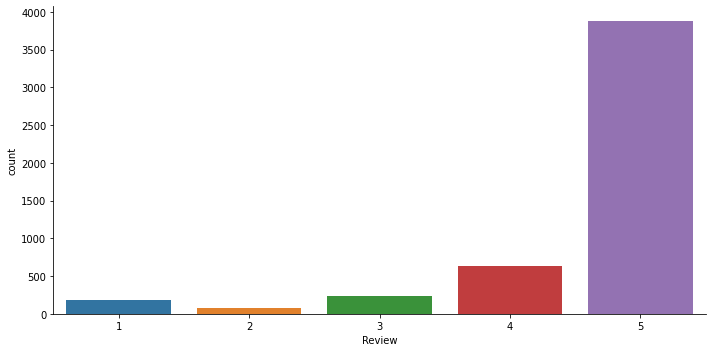

In [110]:
sn.catplot(x='Review', kind='count', data=df, aspect=2)
plt.show()

In [111]:
df['Review'] = df['Review'].replace([1,2,3,4], 0)
df['Review'] = df['Review'].replace([5], 1)

In [112]:
df.head()

,Nome,Titulo,Texto,Data,Review
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",2019,1
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,2019,0
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,2019,0
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",2019,0
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,2019,1


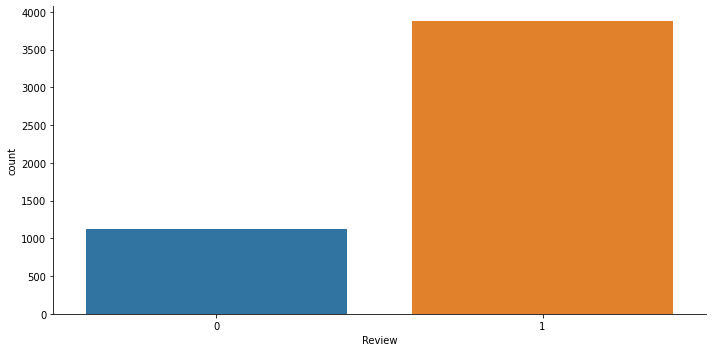

In [113]:
sn.catplot(x='Review', kind='count', data=df, aspect=2)
plt.show()

In [114]:
df["Review"].value_counts()

1    3879
0    1121
Name: Review, dtype: int64

In [115]:
df["Tokens"] = df["Texto"]
df["Stemmer"] = df["Texto"]

In [116]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [117]:
import string
import spacy
import pt_core_news_sm

nlp = pt_core_news_sm.load()

stopwors_spacy = spacy.lang.pt.stop_words.STOP_WORDS
stopwors_nltk = nltk.corpus.stopwords.words('portuguese')
alfabeto = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'w', 'y', 'z']


tokens = []
for i in range(df.shape[0]):
    s = df.loc[i, "Texto"]

    s = s.lower()

    s = remove_emoji(s)

    s = re.sub('kkk*', '', s, flags=re.IGNORECASE)
    s = re.sub('rsr*', '', s, flags=re.IGNORECASE)
    s = re.sub('haha*', '', s, flags=re.IGNORECASE)

    s = s.replace('’', '').replace('‘', '').replace('’’', '').replace('“', '').replace('”', '')
    s = s.replace("'", '').replace('"', '').replace(',', '.')
    
    s = s.replace('!', ' ').replace(':', ' ').replace(';', ' ')
    s = s.replace(')', ' ').replace('(', ' ').replace('±', ' ')
    s = s.replace('/', ' ').replace('\\', ' ').replace('//', ' ')

    s = s.replace('–', ' ').replace('—', ' ').replace('•', ' ')
    s = s.replace('…', ' ').replace('}', ' ').replace('±', ' ')

    s = s.replace('*', ' ').replace('%', ' ').replace('$', ' ')
    s = s.replace('#', ' ').replace('–', ' ').replace('—', ' ')
    s = s.replace('@', ' ').replace('&', ' ')

    s = s.replace('{', ' ').replace('––', ' ').replace('--', ' ')
    
    s = s.replace('<', ' ').replace('?', ' ').replace('`', ' ')
    
    s = s.replace(' gb', 'gb').replace('wiffi', 'wi-fi').replace('wifi', 'wi-fi').replace('w-ifi', 'wi-fi')
    
    s = s.replace('ésuper', 'é super').replace('éé', 'é').replace('è', 'é')
    s = s.replace('ñ', 'não').replace('òtimo', 'ótimo')
    s = s.replace('ótimaaa', 'ótima').replace('ótimasperfeito', 'ótimas perfeito')
    s = s.replace('ótimoo', 'ótimo').replace('ė', 'é').replace('vaaaarios', 'vários')
    s = s.replace('vaaarias', 'várias') .replace('valeeeus', 'valeus').replace('varias', 'várias')
    s = s.replace('varios', 'vários').replace('vc', 'você').replace('vcs', 'vocês').replace('vdd', 'verdade')

    s = s.replace('viagensresolvi', 'viagens resolvi').replace('vidaaa', 'vida').replace('vistaa', 'vista')
    s = s.replace('vocabuláriostradução', 'vocabulários tradução').replace('voce', 'você')
    s = s.replace('voces', 'vocês').replace('vontadesuper', 'vontade super').replace('váaaarios', 'vários')

    s = s.replace('àqueles', 'aqueles').replace('àquilo', 'aquilo').replace('whatssap', 'whatsapp')
    s = s.replace('whhite', 'white').replace('taaanto', 'tanto').replace('tanra', 'tanta').replace('tantoo', 'tanto')
    s = s.replace('tblet', 'tablet').replace('tbm', 'também').replace('td', 'tudo').replace('tdo', 'tudo')
    s = s.replace('tds', 'todos').replace('tecidosuas', 'tecido suas').replace('teconlogia', 'tecnologia')
    s = s.replace('telaenvio', 'tela envio').replace('telapor', 'tela por').replace('telaum', 'tela um')
    s = s.replace('telegran', 'telegram').replace('tenjo', 'tenho').replace('titulos', 'títulos')
    s = s.replace('titulo', 'título').replace('tambem', 'também').replace('tochscreen', 'touchscreen')
    s = s.replace('touch-screen', 'touchscreen').replace('touchscreen', 'touchscreen').replace('touché', 'touch')
    s = s.replace('toucshscreen', 'touchscreen').replace('toutch', 'touch')

    s = s.replace('traqnuilamente', 'tranquilamente').replace('tristeos', 'triste os').replace('tristetem', 'triste tem')
    s = s.replace('tudooo', 'tudo').replace('uahuashusah', '').replace('ulimited', 'unlimited')
    s = s.replace('táctil', 'tátil').replace('ulinmited', 'unlimited').replace('ullimited', 'unlimited')
    s = s.replace('umaleitura', 'uma eitura').replace('ume', 'um e').replace('umlimited', 'unlimited')
    s = s.replace('ummês', 'um mês').replace('umsmartphone', 'um smartphone').replace('univeidade', 'universidade')
    s = s.replace('univeitário', 'universitário').replace('univeitários', 'universitários').replace('unilimed', 'unlimited')
    s = s.replace('unilimites', 'unlimiteds').replace('unimited', 'unlimited').replace('unlimeted', 'unlimited')
    s = s.replace('unlimitade', 'unlimited').replace('unlmited', 'unlimited').replace('up-grade', 'upgrade')
    s = s.replace('usar-ló', 'usá-lo').replace('usuario', 'usuário').replace('usuárioo', 'usuário')
    s = s.replace('usá-lousei', 'usá-lo usei').replace('utilizaçãodesign', 'utilização design')
    s = s.replace('utilizalo', 'utiliza-lo').replace('utilizacao', 'utilização').replace('utlização', 'utilização')
    s = s.replace('seguintr', 'seguinte').replace('segunndo', 'segundo').replace('semanas-de', 'semanas de')
    s = s.replace('siiiiim', 'sim').replace('siteque', 'site que').replace('sitesno', 'sites no')
    s = s.replace('skdksksks', '').replace('smartfone', 'smartphone').replace('smartfones', 'smartphone')
    s = s.replace('smarthphone', 'smartphone').replace('smartphones', 'smartphone').replace('smatfone', 'smartphone')
    s = s.replace('sminha', 's minha').replace('sensivel', 'sensível')
    s = s.replace('squando', 'quando').replace('ssim', 'assim')
    s = s.replace('ssmas', 'mas').replace('sso', 'so').replace('sss', '')
    s = s.replace('ssó', 'só').replace('substituiçãonão', 'substituição não')
    s = s.replace('suficientepontos', 'suficiente pontos').replace('superficie', 'superfície')
    s = s.replace('suuuper', 'super').replace('suuuuper', 'super').replace('sabado', 'sábado')
    s = s.replace('sábadomas', 'sábado mas').replace('sérioo', 'sério')
    s = s.replace('ramazon', 'amazon').replace('rapido', 'rápido').replace('reaaais', 'reais')
    s = s.replace('realmene', 'realmente').replace('recebee', 'recebe')
    s = s.replace('recomendadiimo', 'recomendadíssimo').replace('recomendadíimo', 'recomendadíssimo')
    s = s.replace('recomendosó', 'recomendo só').replace('referencia', 'referência')
    s = s.replace('referencias', 'referências').replace('refleteconsigo', 'reflete consigo')
    s = s.replace('removee', 'remove').replace('residencia', 'residência').replace('resistencia', 'resistência')
    s = s.replace('resumopontos', 'resumo pontos').replace('resvistas', 'revistas').replace('roteae', 'rotear')
    s = s.replace('rsr', '').replace('ruafavor', 'rua favor').replace('ruimproceamento', 'ruim proceamento')
    s = s.replace('rápidoque', 'rápido que').replace('rápidoé', 'rápido é')
    s = s.replace('aaah', ' ').replace('aaim', ' ').replace('aalimentando', 'alimentando')
    s = s.replace('absurdonão', 'absurdo não').replace('acabeibde', 'acabei de').replace('academico', 'acadêmico')
    s = s.replace('acontecee', 'acontece').replace('acstumados', 'acostumados').replace('adapatar', 'adaptar')
    s = s.replace('adaptr', 'adaptar').replace('adoreiiiii', 'adorei').replace('adquiridocomo', 'adquirido como')
    s = s.replace('agorq', 'agora').replace('aguardomaria', 'aguardo maria').replace('aimda', 'ainda')
    s = s.replace('acesíveis', 'acessíveis').replace('acessibiilidade', 'acessibilidade')

    
    s = s.replace('ajudawww', 'ajuda').replace('ajustavel', 'ajustável').replace('ajustavél', 'ajustável')
    s = s.replace('aleatorias', 'aleatórias').replace('alguem', 'alguém').replace('aliásvale', 'aliás vale')
    s = s.replace('amandoooooo', 'amando').replace('amanha', 'amanhã').replace('amarzenamento', 'armazenamento')
    s = s.replace('amazom', 'amazon').replace('ameiiiiiiiii', 'amei').replace('ameiiiiiii', 'amei')
    s = s.replace('ameiiii', 'amei').replace('ameiii', 'amei').replace('ameii', 'amei').replace('ameeeeei', 'amei')

    s = s.replace('ameeei', 'amei').replace('amgs', 'amigos').replace('amoooooo', 'amo').replace('amouuu', 'amou')
    s = s.replace('amem', 'amém').replace('analise', 'análise').replace('androi', 'android')
    s = s.replace('aniveario','aniversário').replace('aniveário','aniversário').replace('apaptável', 'adaptável')
    s = s.replace('aparaceu', 'apareceu').replace('apararelho', 'aparelho').replace('aparelhofica', 'aparelho fica')
    s = s.replace('aparelhoo', 'aparelho').replace('aparelhoquando', 'aparelho quando').replace('apemas', 'apenas')
    s = s.replace('apena', 'apenas').replace('aprovadíassimo', 'aprovadíssimo').replace('aprovietar', 'aproveitar')
    s = s.replace('aproximandamente', 'aproximadamente').replace('aquivos', 'arquivos').replace('aranha', 'arranha')
    s = s.replace('armanezamento', 'armazenamento').replace('armazenento', 'armazenamento').replace('arquvivos', 'arquivos')
    s = s.replace('asletras', 'asociado').replace('assistencia','assistência')
    s = s.replace('atenciosamentemarilia', 'atenciosamente marilia').replace('atençâo', 'atenção')
    s = s.replace('atraves', 'atráves').replace('atualizaçao', 'atualização')
    s = s.replace('auxilio', 'auxílio').replace('av4u6bf9k', '').replace('aveão', 'avião').replace('aviao', 'avião')
    s = s.replace('avrias', 'a várias').replace('avárias', 'a várias').replace('aínda', 'ainda')
    s = s.replace('dagua', 'dágua').replace('agua', 'água').replace('wikipedia', 'wikipédia')

    s = s.replace('baixiassima', 'baixíassima').replace('baratodesvantagens', 'barato desvantagens').replace('baratofora', 'barato fora')
    s = s.replace('bateriacoloquei', 'bateria coloquei').replace('batistasalvador', 'batista salvador').replace('beeeeem', 'bem')
    s = s.replace('beeem', 'bem').replace('beem', 'bem').replace('bemmm', 'bem').replace('bemrecomendo', 'bem recomendo')
    s = s.replace('beneficio', 'benefício').replace('beneficios', 'benefícios') .replace('benefícos', 'benefícios') 
    s = s.replace('biblia', 'bíblia').replace('bolsaaaaaaa', 'bolsa').replace('bomiluminação', 'bom iluminação')
    s = s.replace('bomntes', 'bom antes').replace('bompode', 'bom pode').replace('bomvaleu', 'bom valeu')
    s = s.replace('brancoademais', 'branco a demais').replace('brancoum', 'branco um').replace('capas', 'capaz')
    s = s.replace('capinhamas','capinha mas').replace('carreagdor', 'carregador').replace('cenasliterarias', 'cenas literarias')
    s = s.replace('chatiinho', 'chatinho').replace('chatopois', 'chato pois').replace('chegouu', 'chegou')

    s = s.replace('complento', 'complemento').replace('compleramente', 'completamente').replace('completamete', 'completamente')
    s = s.replace('complicacoes','complicações').replace('conaegui', 'consegui').replace('confiavél', 'confiável')

    s = s.replace('configuracao', 'configuração').replace('confortavel', 'confortável').replace('confortáel', 'confortável')
    s = s.replace('confortáve', 'confortável') .replace('confortávelpoderia', 'confortável poderia').replace('conforável', 'confortável')

    s = s.replace('conprei', 'comprei').replace('conservarprós', 'conservar prós').replace('consideravemente', 'consideravelmente')
    s = s.replace('custo-beneficio', 'custo-benefício').replace('amazoz', 'amazon').replace('antireflexo', 'anti-reflexo')
    s = s.replace('antirreflexo', 'anti-reflexo').replace('daamazon', 'da amazon')
    s = s.replace('dedosmas', 'dedos mas').replace('defeitotoda', 'defeito toda').replace('deitoem', 'deito em')
    s = s.replace('dele-não', 'dele não').replace('demaaaaais', 'demais').replace('demaisleveamo', 'demais leve amo')
    s = s.replace('demaisme', 'demais me').replace('desagravel', 'desagradável').replace('desconfortávell', 'desconfortável')
    s = s.replace('designe', 'design').replace('designer', 'design').replace('desing', 'design')
    s = s.replace('despositivo', 'dispositivo').replace('diapositivo', 'dispositivo').replace('dicionario', 'dicionário')
    s = s.replace('dicionarios', 'dicionários').replace('dificil', 'difícil').replace('dificulade', 'dificuldade')
    s = s.replace('difixil', 'difícil').replace('digoalgo', 'digo algo').replace('dipositivo', 'dispositivo')
    s = s.replace('diretomais', 'direto mais').replace('disign', 'design').replace('disigner', 'design')
    s = s.replace('dispoaitivo', 'dispositivo').replace('disponivel', 'disponível').replace('disponível5', 'disponível')
    s = s.replace('disponíves', 'disponíveis').replace('dispositivoedit', 'dispositivo edit').replace('dispositvo', 'dispositivo')
    s = s.replace('dispositvos', 'dispositivos').replace('distracoes', 'distrações').replace('dmaaais', 'demais')
    s = s.replace('dmais', 'demais').replace('dms', 'demais').replace('dnv', 'de novo')
    s = s.replace('dowload', 'download').replace('e-mail3', 'e-mail').replace('ebooksgratuitoss', 'ebooks gratuitos')
    s = s.replace('eexcelente', 'excelente').replace('eletronicos', 'eletrônicos').replace('emails', 'e-mails')
    s = s.replace('emais', 'e-mails').replace('email', 'e-mail').replace('emcontato','em contato')
    s = s.replace('enconomia', 'economia').replace('enconomiza', 'economiza').replace('entao', 'então')
    s = s.replace('entaoatendeu', 'então atendeu').replace('ernome', 'enorme').replace('espaçocoisas', 'espaço coisas')
    s = s.replace('especifico', 'específico').replace('espectativa', 'expectativa').replace('espectativas', 'expectativas')
    s = s.replace('esperiecia', 'experiência').replace('essaa', 'essa').replace('estoucontando', 'estou contando')
    s = s.replace('estremamente', 'extremamente').replace('estáigual', 'está igual').replace('etctambém', 'etc também')
    s = s.replace('eternaexcelente', 'eterna excelente').replace('exatamenre', 'exatamente').replace('excelentemuito', 'excelente muito')
    s = s.replace('excelenteo', 'excelente o').replace('exclente', 'excelente').replace('execelente', 'excelente')
    s = s.replace('exelente', 'excelente').replace('expectatias', 'expectativas').replace('expectativasdá', 'expectativas dá')
    s = s.replace('experiencia', 'experiência')
    
    s = s.replace('familia', 'família').replace('fantastica', 'fantástica').replace('fantastico', 'fantástico')
    s = s.replace('ficaadica', 'fica a dica').replace('finalproduto', 'final produto').replace('fluidas', 'fluídas')
    s = s.replace('fluido', 'fluído').replace('flúida', 'fluída').replace('funcao', 'função')
    s = s.replace('funcionalidadea', 'funcionalidade').replace('funcionalidadessempre', 'funcionalidades sempre')
    s = s.replace('funcoes', 'funções').replace('funvoes', 'funções').replace('fabrica', 'fábrica').replace('geracao', 'geração')
    s = s.replace('geração10', 'geração 10').replace('gigantee', 'gigante').replace('gratuitous', 'gratuitos')
    s = s.replace('gratuítos', 'gratuitos').replace('haalém', 'ha além').replace('hardwarea', 'hardware a')
    s = s.replace('heheachei', 'achei').replace('hehehehe', '').replace('hehehe', '').replace('hehe', '').replace('hihi', 'hihihihi') 
    s = s.replace('hj', 'hoje').replace('horrivel', 'horrível').replace('horáriosinclusive', 'horários inclusive')
    s = s.replace('http', '').replace('www', '').replace('hábitonão', 'hábito não').replace('hórario', 'horário')
    s = s.replace('idealtava', 'ideal tava').replace('idéia', 'ideia').replace('igualrecebi', 'igual recebi')
    s = s.replace('iiuminação', 'iluminação').replace('iluminacao', 'iluminação').replace('iluminaçõa', 'iluminação')
    s = s.replace('iluminção', 'iluminação').replace('ilumição', 'iluminação').replace('impecavel', 'impecável')
    s = s.replace('imperceptivel', 'imperceptível').replace('impressao', 'impressão').replace('inadimissível', 'inadmissível') 
    s = s.replace('inagem', 'imagem').replace('inclivel', 'incrível').replace('inclível', 'incrível').replace('incomada', 'incomoda')
    s = s.replace('incompativel', 'incompatível').replace('incrivel', 'incrível').replace('incrével', 'incrível')
    s = s.replace('incomodo', 'incômodo').replace('informções', 'informações').replace('inglêsgostaria', 'inglês gostaria')
    s = s.replace('inicialpara', 'inicial para').replace('invesmento', 'investimento').replace('irao', 'irão')
    s = s.replace('irritadomais', 'irritado mais').replace('jurooooootipo', 'juro tipo').replace('kakaka', '')
    s = s.replace('kidle', 'kindle').replace('kidles', 'kindles').replace('kinde', 'kindle')
    s = s.replace('kindel', 'kindle').replace('kindke', 'kindle').replace('kindle-10', 'kindle')
    s = s.replace('kindleai', 'kindle').replace('kindlemas', 'kindle mas').replace('kindlepaperwhite', 'kindle paperwhite')
    s = s.replace('kindler', 'kindle').replace('kindleunided', 'kindle unlimited').replace('kindleunlimited', 'kindle unlimited')
    s = s.replace('kindlle', 'kindle').replace('kindlo', 'kindle').replace('kindlwos', 'kindle').replace('kindlé', 'kindle')
    s = s.replace('kinkdle', 'kindle').replace('kinkle', 'kindle').replace('kinlde', 'kindle').replace('kinldle', 'kindle')

    s = s.replace('leitua', 'leitura').replace('leituas', 'leituras').replace('leituraa', 'leitura')
    s = s.replace('leituraaaa', 'leitura').replace('leiturano', 'leitura no').replace('leituraobs', 'leitura obs')
    s = s.replace('lentonão', 'lento não').replace('lerchegou', 'ler chegou').replace('lernesse', 'ler nesse')
    s = s.replace('leveeeeeeeee', 'leve').replace('leviassimo', 'levíassimo').replace('levvíassimo', 'levíassimo')
    s = s.replace('lindooo', 'lindo').replace('lindooveio', 'lindo o veio').replace('linhaplumas', 'linha plumas')
    s = s.replace('literarias', 'literárias').replace('livrodigitaldebolso', 'livro digital de bolso')
    s = ss = s.replace('looonnngggaaaa', 'longa').replace('loucaaa', 'louca').replace('lugartem', 'lugar tem')
    s = s.replace('luzdecepcionado', 'luz decepcionado').replace('logica', 'lógica').replace('lúgar', 'lugar')
    s = s.replace('m-a-r-a-v-i-l-h-o-s-o', 'maravilhoso').replace('maaaaass', 'mas').replace('maaaaas', 'mas')
    s = s.replace('maaas', 'mas').replace('maisamei', 'mais amei').replace('maisgb', 'mais gb')
    s = s.replace('manhas', 'manhãs').replace('mantem', 'mantém').replace('manuseavel', 'manuseável')
    s = s.replace('maravilhaaa', 'maravilha').replace('maravilhosaeu', 'maravilhosa eu')
    s = s.replace('maravilhosomelhor', 'maravilhoso melhor').replace('maravilhosooo', 'maravilhoso')
    s = s.replace('maravilhosoooo', 'maravilhoso').replace('memoria', 'memória').replace('mes', 'mês')
    s = s.replace('mesmk', 'mesmo').replace('mesmogb', 'mesmo gb').replace('mesmops', 'mesmo ps')
    s = s.replace('meucarrego', 'meu carrego').replace('mmmmuuiiitoo', 'muito').replace('muiiiiiiiitoooo', 'muito')
    s = s.replace('muiiiiiito', 'muito').replace('muiiiito', 'muito').replace('muiiito', 'muito').replace('muiiitoooooooo', 'muito')
    s = s.replace('muio', 'muito').replace('muitaaa', 'muita').replace('muitoooooo', 'muito').replace('muitooooo', 'muito')
    s = s.replace('muitoooo', 'muito').replace('muitooo','muito').replace('muitooos', 'muitos').replace('muitoos', 'muitos')
    s = s.replace('muitoo', 'muito').replace('muitãoooo', 'muitão').replace('muuuuuuiiiittttoooo', 'muito')
    s = s.replace('muuuuuuiiiitooooo', 'muito')
    s = s.replace('muuuuuito', 'muito').replace('muuuuuitos', 'muitos').replace('muuuuiiito', 'muito')
    s = s.replace('muuuuuuuitos', 'muitos').replace('muuuuiiito', 'muito').replace('muuuuitos', 'muitos')
    s = s.replace('muuuuito', 'muito').replace('muuuitos', 'muitos').replace('muuuito', 'muito')
    s = s.replace('muuitos', 'muitos').replace('muuuita', 'muita').replace('muuito', 'muito').replace('muuto', 'muito')
    s = s.replace('muuuitoagilidade', 'muito agilidade').replace('mémoria', 'memória').replace('naaada', 'nada')
    s = s.replace('nadameu', 'nada meu').replace('nao', 'não').replace('naoeumtablet', 'não e um tablet' )
    s = s.replace('navegacao', 'navegação').replace('necessario', 'necessário').replace('nescessidade', 'necessidade')
    s = s.replace('ninguem', 'ninguém').replace('nitida', 'nitída').replace('nivel', 'nível').replace('noticia', 'notícia')
    s = s.replace('noticias', 'notícias').replace('nâo', 'não').replace('não-amazon', 'não amazon').replace('nãohoje', 'não hoje')
    s = s.replace('nítidaa', 'nítida').replace('nítidopoderia', 'nítido poderia').replace('off-line', 'offline')
    s = s.replace('ola', 'olá').replace('on-line', 'online').replace('onão', 'o não').replace('opcao', 'opção')
    s = s.replace('opnião', 'opinião').replace('opçõesde', 'opções de').replace('oque', 'o que')
    s = s.replace('outroooooooooooooooo', 'outro').replace('paciênciaavaliação', 'paciência avaliação').replace('padroes', 'padrões')
    s = s.replace('pafamento', 'pagamento').replace('palavrascriação', 'palavras criação')
    s = s.replace('palavrasdicionárioajuda', 'palavras dicionário ajuda').replace('papaewhite', 'paperwhite')
    s = s.replace('paperwaith', 'paperwhite').replace('paperwater', 'paperwhite').replace('paperwath', 'paperwhite')
    s = s.replace('paperwhate', 'paperwhite').replace('paperwhiteresolução', 'paperwhite').replace('paperwhrite', 'paperwhite')
    s = s.replace('paperwite', 'paperwhite').replace('paperwithe', 'paperwhite').replace('paperwrite', 'paperwhite')
    s = s.replace('papperwhite', 'paperwhite').replace('papperwite', 'paperwhite').replace('papperwrite', 'paperwhite')
    s = s.replace('papwerwhite', 'paperwhite').replace('parabens', 'parabéns').replace('paralevar', 'para levar')
    s = s.replace('pedidaa', 'pedida').replace('pelicula', 'película').replace('peliculas', 'películas')
    s = s.replace('penaaaa', 'pena').replace('penacomprei', 'pena comprei').replace('pepectiva', 'perspectiva')
    s = s.replace('peperwhite', 'paperwhite').replace('pepperwhite', 'paperwhite').replace('per-fei-to', 'perfeito')
    s = s.replace('perceptivel', 'perceptível').replace('perdao', 'perdão').replace('perfeitobateria', 'perfeito bateria')
    s = s.replace('perfeitooooo', 'perfeito').replace('perfeitoooo', 'perfeito').replace('perfeitooo', 'perfeito')
    s = s.replace('pesoais', 'pessoais').replace('pesoal', 'pessoal').replace('pesoas', 'pessoa').replace('pesoa', 'pessoa')
    s = s.replace('porem', 'pórem').replace('portabiidade', 'portabilidade').replace('portatil', 'portátil')
    s = s.replace('portugues', 'português').replace('positivoslevepráticofácil', 'positivos leve prático fácil')
    s = s.replace('possibilidadefe', 'possibilidade fe').replace('possiblidade', 'possibilidade')
    s = s.replace('possivel', 'possível').replace('potencia', 'potência').replace('poucooooo', 'pouco')
    s = s.replace('pprwhite', 'paperwhite').replace('praqueumkindle', 'pra que um kindle').replace('preçoo','preço')
    s = s.replace('principio', 'princípio').replace('probemas', 'problemas').replace('probleminhaa', 'probleminha')
    s = s.replace('problrma', 'problema').replace('produtoachei', 'produto achei').replace('produtofora', 'produto fora')
    s = s.replace('produtro', 'produto').replace('proprio', 'próprio').replace('própio', 'próprio').replace('publico', 'público')
    s = s.replace('quecusta', 'que custa')
    
    s = s.replace('0.5a', '0.5 a').replace('06chegou', '06 chegou').replace('1.99.ler', '1.99 ler')
    s = s.replace('1.99.é', '1.99 é').replace('1.99r', '1.99 r').replace('1.°', '1°').replace('10.a', '10 a')
    s = s.replace('10.compacto', '10 compacto').replace('10.°', '10°').replace('10a', '10 a').replace('10geração', '10 geração')
    s = s.replace('10sobre', '10 sobre').replace('10°g', '10° g').replace('10°gen', '10°g').replace('10°geração', '10° geração')
    s = s.replace('11.a', '11 a').replace('1a', '1 a').replace('2.5gb.resumindo', '2.5gb resumindo') 
    s = s.replace('2.75gb.impossível', '2.75gb impossível').replace('2.75gbé', '2.75gb é').replace('2.estou', '2 estou')
    s = s.replace('2.°', '2°').replace('2019.resumo', '2019 resumo').replace('21-quase', '21 quase')
    s = s.replace('255.é', '255 é').replace('289.00recomendo', '289.00 recomendo').replace('30h.não', '30h não')
    s = s.replace('30minutos', '30 minutos').replace('3era', '3 era').replace('3indico', '3 indico') 
    s = s.replace('4gbreal', '4gb real').replace('4gigas', '4 gigas').replace('6gb.a', '6gb a') 
    s = s.replace('6gb.mas', '6gb mas').replace('6gb.se', '6gb se').replace('6gb.tirando', '6gb tirando')
    s = s.replace('6gbhá', '6gb há').replace('701-5828988-9904255.entretanto', 'entretanto')
    s = s.replace('70a', '70 a').replace('8a.ele', '8 a ele').replace('8gen', '8 gen')
    s = s.replace('8giga', '8 giga').replace('8gigas', '8 gigas').replace('8ªgeração', '8ª geração')
    s = s.replace('8°ger', '8°').replace('8°geração', '8° geração')
    s = s.replace('androidd', 'android').replace('logistica', 'logística').replace('logico', 'lógico').replace('maravilhosoo', 'maravilhoso')
    
    s = s.replace('aassimilar', 'assimilar').replace('aassimilação', 'assimilação').replace('aassimé', 'assim é')
    s = s.replace('90.quanto', '90 quanto').replace('aaassim', 'assim').replace('aassim', 'assim')
    s = s.replace('acessivel','acessível').replace('video', 'vídeo').replace('videos', 'vídeos').replace('vicio', 'vício')
    s = s.replace('mêsmo', 'mesmo')
    s = s.split()

    text = []
    for word in s:
        if word not in string.punctuation:
            word = word.strip()
            word = word.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~–//—')
            word = word.strip()
            
            if len(word) > 0:
                if not word[0].isdigit():
                    word = word.replace('.', ' ')

                    for w in word.split():
                        wd = w.strip()
                        wd = wd.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~–//—')
                        wd = wd.strip()
                        if wd not in stopwors_nltk:
                            if wd not in alfabeto:
                                text.append(wd)
                                tokens.append(wd)
                else:
                    if word not in stopwors_nltk:
                        if word not in alfabeto:
                            text.append(word)
                            tokens.append(word)
                    


    s = " ".join(text)
    df.loc[i, "Tokens"] = s


#print(sorted(list(set(todos))), "\n")
#print(len(list(set(tokens))))

In [118]:
stemmer = RSLPStemmer()

tokens = []
for i in range(df.shape[0]):
    s = df.loc[i, "Tokens"]
    
    words = []
    steming = []
    
    doc = word_tokenize(s)
    for word in doc:
        tokens.append(word)
        words.append(word)
        steming.append(stemmer.stem(word))

                   
    s = ' '.join(words)
    df.loc[i, "Tokens"] = s

    s = ' '.join(steming)
    df.loc[i, "Stemmer"] = s
    
#print(len(list(set(tokens))))
#print(sorted(list(set(tokens)))) 


In [119]:
df.head()

,Nome,Titulo,Texto,Data,Review,Tokens,Stemmer
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",2019,1,apesar oferecer 4gb sistema consome quase 2gb ...,apes oferec 4gb sistem consom quas 2gb aind as...
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,2019,0,adorei ganhei 90 dias leitura grátis fica apar...,ador ganh 90 dia leit grátil fic aparec 30 dia
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,2019,0,maravilhoso ainda procurando 4gb memória,maravilh aind procur 4gb memór
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",2019,0,produto gostei experiência primeira vez uso ki...,produt gost experi prim vez uso kindl ach saca...
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,2019,1,poso comparar outras geração pois primeiro kin...,pos compar outr ger poi prim kindl pesso gost ...


In [120]:
from nltk.probability import FreqDist
frequencia = nltk.FreqDist(tokens)
lista = frequencia.most_common()
for i in lista[0:10]:
    print(i[0], i[1])

kindle 4152
ler 2771
bateria 2436
leitura 2373
livros 2314
tela 1697
produto 1586
luz 1541
pra 1540
bem 1449


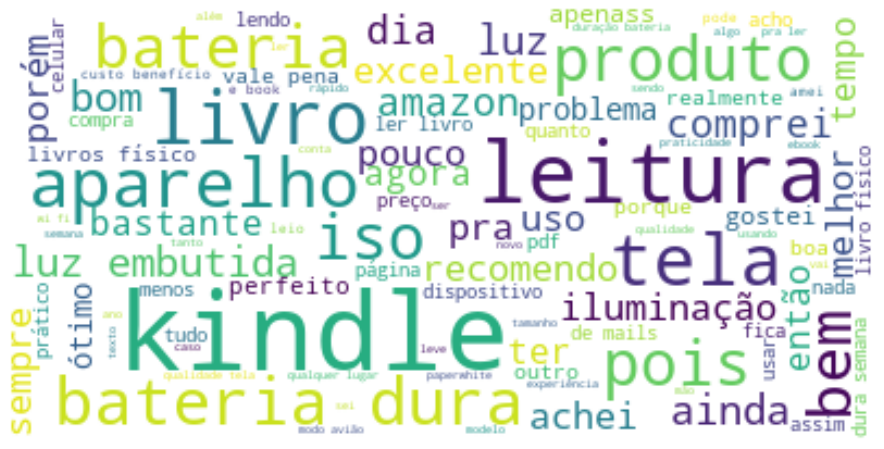

In [121]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join([review for review in df["Tokens"]])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df["Data"].value_counts()

2021    1874
2020    1830
2019     990
2022     306
Name: Data, dtype: int64

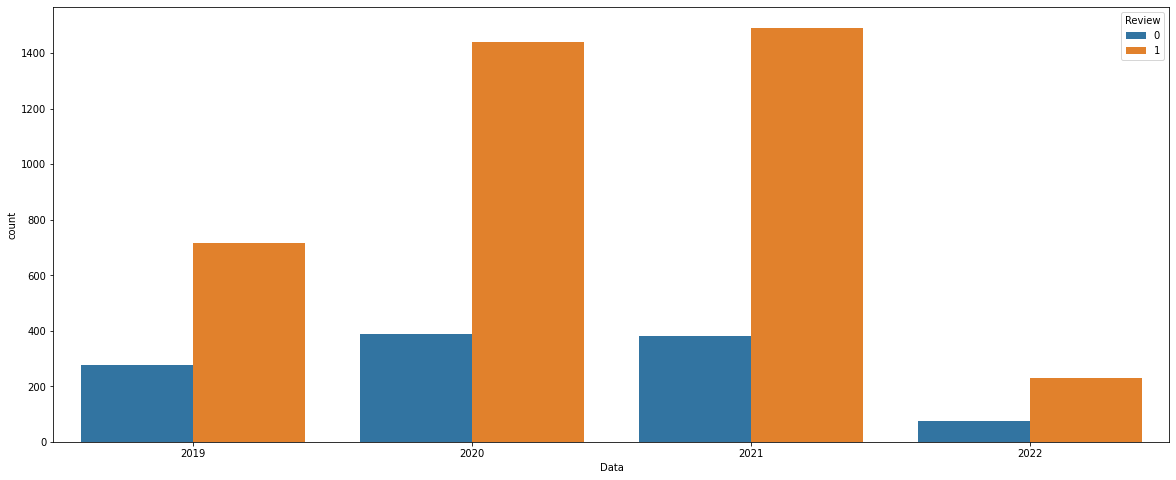

In [ ]:
plt.figure(figsize=(20,8))
sn.countplot(x ='Data', hue ='Review', data = df)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
corpus = df["Tokens"].tolist()
corpus[:5]

['apesar oferecer 4gb sistema consome quase 2gb ainda assim cabe muita coisa considerando livro 738 páginas média 2mb cabem mil iguais precisa fazer download mantenha arquivado biblioteca online baixe ler mantenha prioridades baixadas tipo uns 500 nunca vai gastar memória cores tela coloridas momento algum variam tons cinza dependendo cor original resolução imagens boa textos limpíassima hd ter noção iluminação interna perfeita vem 24 volum es 5° volum pode ler confortávellmente ambiente totalmente luz sol 0 volum es parece folha papel reflete nada dura semanas significa 2 semanas estando modo avião sempre tela hibernando desligada uso usei todos dias recarrega super rápido tomada carregador comum comprem fonte carregador parte todos smartphone mêsma fonte recarrega 0 100 2h meia tomada fonte samsung utilizei qualquer serve cabo vem caixa kindle irrita pouco velocidade to ques comando procuro algum livro demora subir página durante leitura virando folhas queixas notas dicionário procur

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)


In [ ]:
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

5000 rows


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
volum,0.181002,0.0,0.0,0.0,0.0,0.0,0.0,0.072919,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
whispeync,0.165181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atualização,0.155491,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mantenha,0.148556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recarrega,0.148556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++", random_state=42)
k_means = kmeans.fit(X)

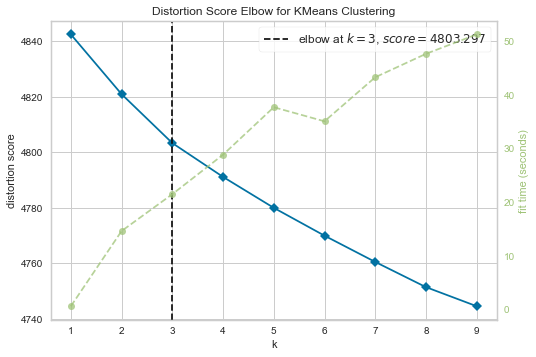

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
visualizer = KElbowVisualizer(KMeans(init="k-means++", random_state=42), k=(1, 10))
visualizer.fit(X)        
visualizer.show()  

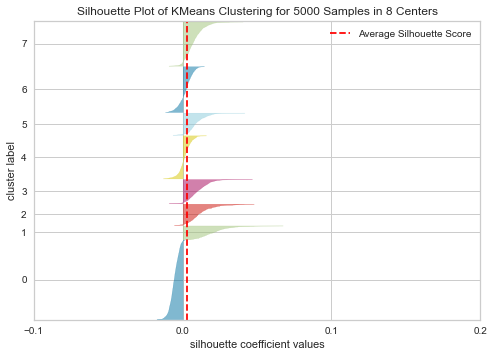

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5000 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
visualizer = SilhouetteVisualizer(KMeans(init="k-means++", random_state=42), colors='yellowbrick')
visualizer.fit(X)        
visualizer.show() 

In [ ]:
from collections import Counter

Counter(k_means.labels_)

Counter({0: 2342, 1: 1545, 2: 1113})

In [ ]:
df['kmeans_cluster'] = k_means.labels_

In [ ]:
movie_clusters = (df[['Tokens', 'kmeans_cluster', 'Review']]
                  .sort_values(by=['kmeans_cluster', 'Review'],ascending=False)
                  .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)

In [ ]:
print("Top terms per cluster:")
order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(NUM_CLUSTERS):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :30]:
        print(terms[ind], end=" ")
    print("\n")

print("Prediction")

Y = vectorizer.transform(['finalmente desapeguei kindle 4º 10º geração mudança luzes perfeitas ler noite escuro cansa vista usa transporte coletivo caso sempre pé kindle pesa cansa braço entrega amazon sensacional comprei sexta-feira segunda mãos super satisfeita serviço entrega feliz kindle novo vai ler piscina banheira modelo perfeito'])
prediction = k_means.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:
kindle produto tela leitura bem comprei amazon aparelho luz geração pouco bom ser chegou recomendo ter qualidade melhor excelente iso gostei iluminação livros compra ótimo achei comprar ler paperwhite bateria 

Cluster 1:
ler livros kindle pra livro leitura qualquer leve luz lugar super ter melhor recomendo físicos bem comprar prático físico sempre levar celular tela bom além fácil pois ser bateria confortávell 

Cluster 2:
bateria dura luz dias semanas kindle ler bastante leitura dia tela uso produto embutida bem semana iluminação duração pra ótimo boa excelente modo pouco qualidade bom leve tempo ainda avião 

Prediction
[0]


In [ ]:
feature_names = vectorizer.get_feature_names()
topn_features = 30
ordered_centroids = k_means.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Tokens'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Key Features: ['kindle', 'produto', 'tela', 'leitura', 'bem', 'comprei', 'amazon', 'aparelho', 'luz', 'geração', 'pouco', 'bom', 'ser', 'chegou', 'recomendo', 'ter', 'qualidade', 'melhor', 'excelente', 'iso', 'gostei', 'iluminação', 'livros', 'compra', 'ótimo', 'achei', 'comprar', 'ler', 'paperwhite', 'bateria']
Popular Movies: ['apesar oferecer 4gb sistema consome quase 2gb ainda assim cabe muita coisa considerando livro 738 páginas média 2mb cabem mil iguais precisa fazer download mantenha arquivado biblioteca online baixe ler mantenha prioridades baixadas tipo uns 500 nunca vai gastar memória cores tela coloridas momento algum variam tons cinza dependendo cor original resolução imagens boa textos limpíassima hd ter noção iluminação interna perfeita vem 24 volum es 5° volum pode ler confortávellmente ambiente totalmente luz sol 0 volum es parece folha papel reflete nada dura semanas significa 2 semanas estando modo avião sempre tela hibernando desligada uso usei todos dias

# LSTM - sem stemming

In [122]:
df_train, df_test = train_test_split(df, test_size = 0.30, random_state = 42, stratify=df["Review"])
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 42, stratify=df_test["Review"])

print(df_train.shape, df_val.shape, df_test.shape)

(3500, 7) (750, 7) (750, 7)


In [123]:
X_train = df_train["Tokens"]
y_train = df_train["Review"]

X_val = df_val["Tokens"]
y_val = df_val["Review"]

X_test = df_test["Tokens"]
y_test = df_test["Review"]


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Determina o tamanho do vocabulário
word_index = tokenizer.word_index
vocab = len(word_index) + 1
print("Tamanho do Vocabulário: ", vocab)

sequences_train = tokenizer.texts_to_sequences(X_train)

# Identificando o comprimento da maior sequência do conjunto de treinamento
names = [len(n) for n in sequences_train]
print("Comprimento da maior sequência: ", max(names))

Tamanho do Vocabulário:  9099
Comprimento da maior sequência:  458


Como as mensagens (texto) no conjunto de dados são de tamanho variável, usaremos o preenchimento para fazer com que todas as mensagens tenham o mesmo tamanho. Podemos usar o comprimento máximo da sequência para preencher as mensagens. No entanto, também podemos dar uma olhada na distribuição dos comprimentos de sequência no conjunto de treino para encontrar o comprimento de preenchimento correto.

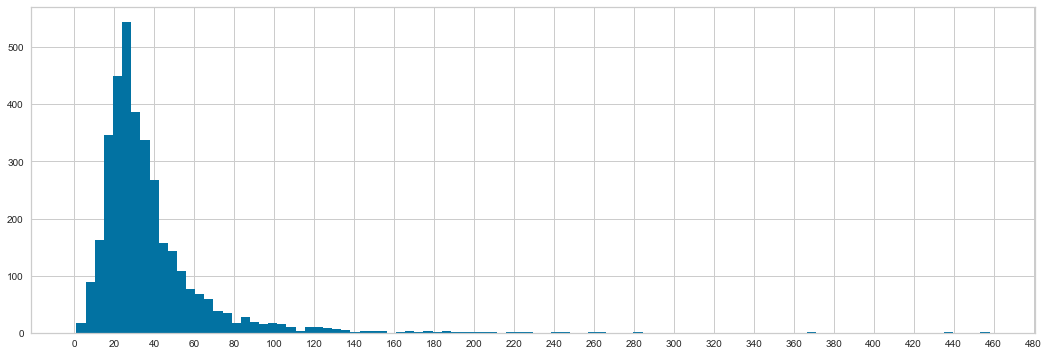

In [ ]:
# Identificando a frêquencia dos comprimentos das sequeência de treinamento
plt.figure(figsize=(18,6))
plt.hist(names, bins = 100)
x_ticks = np.arange(0, 500, 20)
plt.xticks(x_ticks)
plt.show()


Podemos ver claramente que a maioria das mensagens tem um comprimento de 60 palavras ou menos. Considerando que o comprimento máximo é 480. Portanto, se selecionarmos 480 como o comprimento de preenchimento, todas as sequências de entrada terão comprimento 480 e a maioria dos tokens nessas sequências serão tokens de preenchimento que não ajudarão o modelo a aprender nada útil e além disso, tornará o treinamento mais lento.

Portanto, definiremos 60 como o comprimento do preenchimento.

In [124]:
max_length = 60

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

sequences_val = tokenizer.texts_to_sequences(X_val)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')

### Sem Word Embeddings Pré-treinadas

In [125]:
embedding = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab, embedding, input_length=max_length))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 16)            145584    
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 219,953
Trainable params: 219,953
Non-trainable params: 0
_________________________________________________________________


In [126]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_val, y_val))

Epoch 1/10
110/110 [==============================] - 6s 40ms/step - loss: 0.5502 - accuracy: 0.7711 - precision: 0.7758 - recall: 0.9915 - val_loss: 0.5333 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 4s 39ms/step - loss: 0.4693 - accuracy: 0.7949 - precision: 0.8145 - recall: 0.9525 - val_loss: 0.4289 - val_accuracy: 0.8173 - val_precision: 0.8277 - val_recall: 0.9656
Epoch 3/10
110/110 [==============================] - 4s 40ms/step - loss: 0.2990 - accuracy: 0.9017 - precision: 0.9155 - recall: 0.9621 - val_loss: 0.4348 - val_accuracy: 0.8200 - val_precision: 0.8392 - val_recall: 0.9502
Epoch 4/10
110/110 [==============================] - 4s 35ms/step - loss: 0.2194 - accuracy: 0.9374 - precision: 0.9464 - recall: 0.9746 - val_loss: 0.4955 - val_accuracy: 0.8093 - val_precision: 0.8689 - val_recall: 0.8883
Epoch 5/10
110/110 [==============================] - 4s 36ms/step - loss: 0.2301 - accuracy: 0.9111

In [128]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

24/24 [==============================] - 0s 20ms/step - loss: 0.6667 - accuracy: 0.8280 - precision: 0.8545 - recall: 0.9381
Acurácia:  0.828000009059906
Precisão:  0.8544601202011108
F1-Score:  0.8943489070823798
Recall:  0.938144326210022


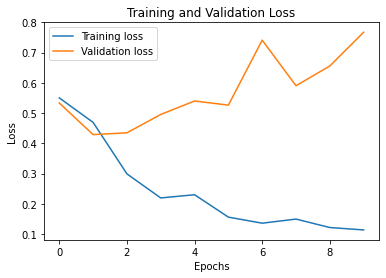

In [129]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

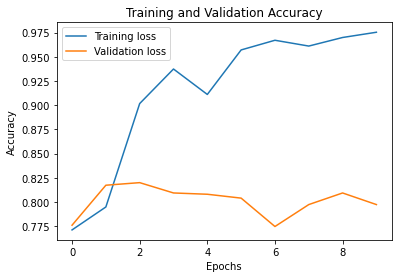

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Com Word Embeddings Pré-treinadas

In [131]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


embeddings = dict()
f = open('glove_s100.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    
    coefs = []
    for coef in values[1:]:
        if(is_float(coef)):
            coefs.append(coef)
    
    coefs = asarray(coefs, dtype='float32')
    embeddings[word] = coefs

f.close()
print(len(embeddings))


929594


In [132]:
from numpy import zeros

embedding_matrix = zeros((vocab, 100))

for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:100]

In [133]:
embedding_layer = keras.layers.Embedding(vocab, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)

model = keras.Sequential()
model.add(embedding_layer)
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           909900    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,027,277
Trainable params: 117,377
Non-trainable params: 909,900
_________________________________________________________________


In [134]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])


In [135]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_val, y_val))

Epoch 1/10
110/110 [==============================] - 6s 40ms/step - loss: 0.5526 - accuracy: 0.7697 - precision: 0.7748 - recall: 0.9912 - val_loss: 0.5413 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 4s 35ms/step - loss: 0.5315 - accuracy: 0.7749 - precision: 0.7758 - recall: 0.9982 - val_loss: 0.5351 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/10
110/110 [==============================] - 4s 34ms/step - loss: 0.5274 - accuracy: 0.7757 - precision: 0.7757 - recall: 1.0000 - val_loss: 0.5357 - val_accuracy: 0.7773 - val_precision: 0.7778 - val_recall: 0.9983
Epoch 4/10
110/110 [==============================] - 4s 33ms/step - loss: 0.5459 - accuracy: 0.7557 - precision: 0.7766 - recall: 0.9617 - val_loss: 0.5323 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 5/10
110/110 [==============================] - 4s 33ms/step - loss: 0.5286 - accuracy: 0.7757

In [136]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)


24/24 [==============================] - 0s 18ms/step - loss: 0.5362 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000
Acurácia:  0.7760000228881836
Precisão:  0.7760000228881836
F1-Score:  0.8738738883868137
Recall:  1.0


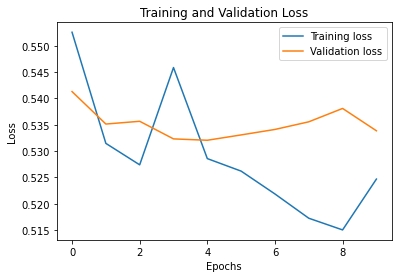

In [137]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

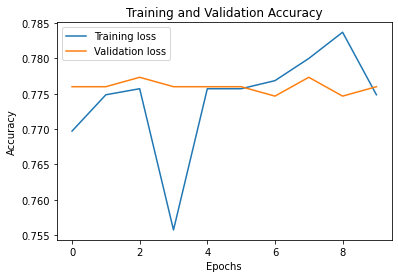

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM - com stemming

In [139]:
df_train, df_test = train_test_split(df, test_size = 0.30, random_state = 42, stratify=df["Review"])
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 42, stratify=df_test["Review"])

print(df_train.shape, df_val.shape, df_test.shape)

(3500, 7) (750, 7) (750, 7)


In [140]:
X_train = df_train["Stemmer"]
y_train = df_train["Review"]

X_val = df_val["Stemmer"]
y_val = df_val["Review"]

X_test = df_test["Stemmer"]
y_test = df_test["Review"]


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Determina o tamanho do vocabulário
word_index = tokenizer.word_index
vocab = len(word_index) + 1
print("Tamanho do Vocabulário: ", vocab)

sequences_train = tokenizer.texts_to_sequences(X_train)

# Identificando o comprimento da maior sequência do conjunto de treinamento
names = [len(n) for n in sequences_train]
print("Comprimento da maior sequência: ", max(names))

Tamanho do Vocabulário:  4412
Comprimento da maior sequência:  458


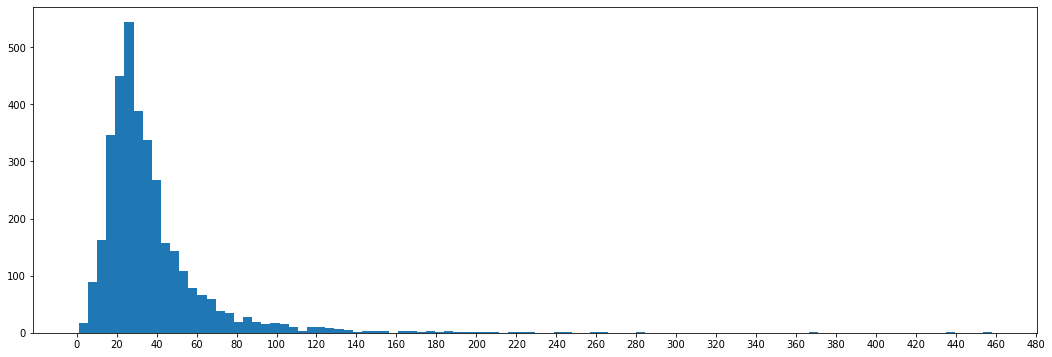

In [141]:
# Identificando a frêquencia dos comprimentos das sequeência de treinamento
plt.figure(figsize=(18,6))
plt.hist(names, bins = 100)
x_ticks = np.arange(0, 500, 20)
plt.xticks(x_ticks)
plt.show()


In [142]:
max_length = 60

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

sequences_val = tokenizer.texts_to_sequences(X_val)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')

### Sem Word Embeddings Pré-treinadas

In [143]:
embedding = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab, embedding, input_length=max_length))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1, activation='softmax'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 16)            70592     
                                                                 
 lstm_2 (LSTM)               (None, 128)               74240     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 144,961
Trainable params: 144,961
Non-trainable params: 0
_________________________________________________________________


In [144]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_val, y_val))

Epoch 1/10
110/110 [==============================] - 6s 40ms/step - loss: 0.5468 - accuracy: 0.7754 - precision: 0.7757 - recall: 0.9996 - val_loss: 0.5389 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 4s 35ms/step - loss: 0.4557 - accuracy: 0.8017 - precision: 0.8133 - recall: 0.9661 - val_loss: 0.4252 - val_accuracy: 0.8293 - val_precision: 0.8603 - val_recall: 0.9313
Epoch 3/10
110/110 [==============================] - 4s 34ms/step - loss: 0.3339 - accuracy: 0.8797 - precision: 0.9059 - recall: 0.9429 - val_loss: 0.4182 - val_accuracy: 0.8067 - val_precision: 0.8980 - val_recall: 0.8471
Epoch 4/10
110/110 [==============================] - 4s 35ms/step - loss: 0.2625 - accuracy: 0.9106 - precision: 0.9358 - recall: 0.9499 - val_loss: 0.4203 - val_accuracy: 0.8293 - val_precision: 0.8673 - val_recall: 0.9210
Epoch 5/10
110/110 [==============================] - 4s 34ms/step - loss: 0.2257 - accuracy: 0.9254

In [146]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

24/24 [==============================] - 1s 20ms/step - loss: 0.5426 - accuracy: 0.8107 - precision: 0.8754 - recall: 0.8814
Acurácia:  0.8106666803359985
Precisão:  0.8754266500473022
F1-Score:  0.8784246833669572
Recall:  0.8814433217048645


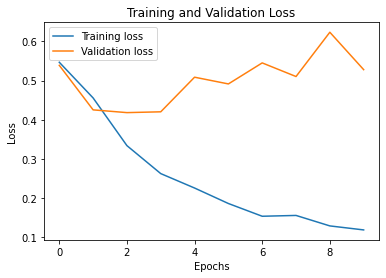

In [147]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

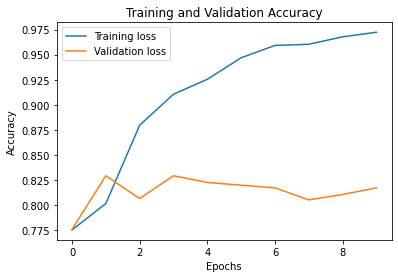

In [148]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Com Word Embeddings Pré-treinadas

In [149]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


embeddings = dict()
f = open('glove_s100.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    
    coefs = []
    for coef in values[1:]:
        if(is_float(coef)):
            coefs.append(coef)
    
    coefs = asarray(coefs, dtype='float32')
    embeddings[word] = coefs

f.close()
print(len(embeddings))


929594


In [150]:
from numpy import zeros

embedding_matrix = zeros((vocab, 100))

for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:100]

In [151]:
embedding_layer = keras.layers.Embedding(vocab, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)

model = keras.Sequential()
model.add(embedding_layer)
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           441200    
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 558,577
Trainable params: 117,377
Non-trainable params: 441,200
_________________________________________________________________


In [152]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])


In [153]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_val, y_val))

Epoch 1/10
110/110 [==============================] - 6s 41ms/step - loss: 0.5370 - accuracy: 0.7729 - precision: 0.7776 - recall: 0.9904 - val_loss: 0.4900 - val_accuracy: 0.7693 - val_precision: 0.7782 - val_recall: 0.9828
Epoch 2/10
110/110 [==============================] - 4s 37ms/step - loss: 0.5392 - accuracy: 0.7640 - precision: 0.7817 - recall: 0.9654 - val_loss: 0.5359 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/10
110/110 [==============================] - 5s 41ms/step - loss: 0.5319 - accuracy: 0.7757 - precision: 0.7757 - recall: 1.0000 - val_loss: 0.5323 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 4/10
110/110 [==============================] - 4s 40ms/step - loss: 0.5310 - accuracy: 0.7757 - precision: 0.7757 - recall: 1.0000 - val_loss: 0.5310 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 5/10
110/110 [==============================] - 4s 38ms/step - loss: 0.5286 - accuracy: 0.7757

In [154]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)


24/24 [==============================] - 1s 23ms/step - loss: 0.5332 - accuracy: 0.7733 - precision: 0.7769 - recall: 0.9931
Acurácia:  0.7733333110809326
Precisão:  0.7768816947937012
F1-Score:  0.8717948631505034
Recall:  0.993127167224884


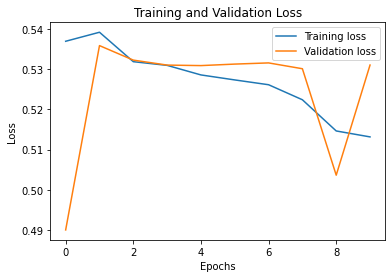

In [155]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

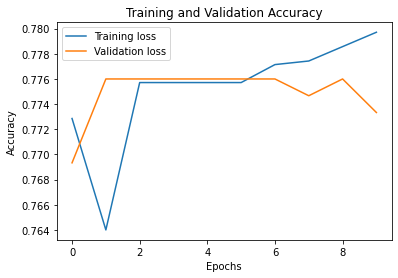

In [156]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()